In [1]:
import razor.flow as rf
from razor import api
import logging
import time
import typing as typ
import numpy as np
import pandas as pd

logger = logging.getLogger()

In [2]:
def project_space_path(path):
    ps = api.datasources('Project Space')
    return os.path.join(ps.abspath(), path)


In [3]:
@rf.block
class STDIn:
    filename: str
    out_ds: rf.Output[typ.Any] = rf.Output(transport=rf.KafkaTransport)

    def run(self):
        df = pd.read_parquet(project_space_path(self.filename))

        logger.info(df.shape)
        self.out_ds.put(df)
        
@rf.block
class AxisSum:
    in_ds: typ.Any
    out_ds: rf.Output[typ.Any] = rf.Output(transport=rf.KafkaTransport)

    def run(self):
        df = self.in_ds.copy()
        df['x_temp'] = df.sum(axis=1)
        self.out_ds.put(df)

        
@rf.block
class SumAxisSum:
    s_in_ds: typ.Any
    l_in_ds: typ.Any
    s_out_ds: rf.Output[typ.Any] = rf.Output(transport=rf.KafkaTransport)
    l_out_ds: rf.Output[typ.Any] = rf.Output(transport=rf.KafkaTransport)

    def run(self):
        s_df = self.s_in_ds.copy()
        logger.info('small df')
        logger.info(s_df['x_temp'].sum())
        
        self.s_out_ds.put(s_df)
        del(s_df)
        
        l_df = self.l_in_ds.copy()
        logger.info('large df')
        logger.info(l_df['x_temp'].sum())
        
        self.l_out_ds.put(l_df)
        
        
@rf.block
class DropAxisSum:
    in_ds: typ.Any
    out_ds: rf.Output[typ.Any] = rf.Output(transport=rf.KafkaTransport)

    def run(self):
        df = self.in_ds.copy()
        df.drop(['x_temp'], axis=1, inplace=True)
        self.out_ds.put(df)
        
        
@rf.block
class STDOut:
    in_ds: typ.Any
    out_filename: str

    def run(self):
        logger.info(self.in_ds.shape)
        self.in_ds.to_parquet(project_space_path(self.out_filename), index=False)
            

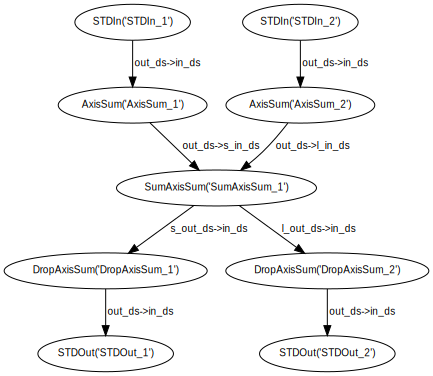

In [4]:
s_size = '10MB'
l_size = '300MB'
s_ip_filename = "sdk_testbench/input_data/dummy_"+s_size+"_df.parquet"
l_ip_filename = "sdk_testbench/input_data/dummy_"+l_size+"_df.parquet"
s_op_filename = "sdk_testbench/output_data/s_tc_20.parquet"
l_op_filename = "sdk_testbench/output_data/l_tc_20.parquet"

s_std_in = STDIn(filename=s_ip_filename)
l_std_in = STDIn(filename=l_ip_filename)
l_std_in.out_ds = rf.Output.set(transport=rf.FileTransport)

s_axis_sum = AxisSum(in_ds=s_std_in.out_ds)
l_axis_sum = AxisSum(in_ds=l_std_in.out_ds)
l_axis_sum.out_ds = rf.Output.set(transport=rf.FileTransport)

sum_axis_sum = SumAxisSum(s_in_ds=s_axis_sum.out_ds, l_in_ds=l_axis_sum.out_ds)
sum_axis_sum.l_out_ds = rf.Output.set(transport=rf.FileTransport)

s_drop_axis_sum = DropAxisSum(in_ds=sum_axis_sum.s_out_ds)
l_drop_axis_sum = DropAxisSum(in_ds=sum_axis_sum.l_out_ds)
l_drop_axis_sum.out_ds = rf.Output.set(transport=rf.FileTransport)

s_stdout = STDOut(in_ds=s_drop_axis_sum.out_ds, out_filename=s_op_filename)
l_stdout = STDOut(in_ds=l_drop_axis_sum.out_ds, out_filename=l_op_filename)

pipeline = rf.Pipeline(name='mix_atomic_parallel', targets=[s_stdout, l_stdout])
pipeline.show()

In [5]:
pipeline.execute()

NameError: name 'os' is not defined